This project aims to provide a hands-on practice for the machine learning(or deep learning) course. In this project, I will use the COVID-19 dataset for image classification task. COVID-19 dataset contains 137 cleaned images of COVID-19 and 317 in total containing Viral Phneumonia and Normal Chest X-Rays structured into the test and train directories. The dataset's structure is showed as below:

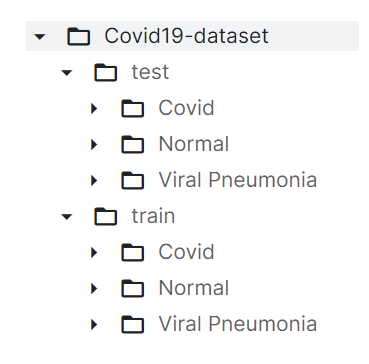

In this project, I will investigate the usage of some deep learning library and try to use pretrained model to help in this task. Since the size of this dataset is fairly limited (317 in total), I think it is necessary to use a pretrained-well model instead of a empty model.

Before using any model, I need to visualize some of the images to help me decide which step to take next. For doing this, I need to first import the matplotlib package to give me a hand on image processing. Also,I need to get the names(paths) of these images.

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0117.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0101.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0108.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0110.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0119.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0115.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0116.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0105.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0106.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0121.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0111.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0103.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0120.jpeg
/kaggle/input/covid19-image-dataset/Co

By now, I could easily tell any path of a given image. So, I am going to visualize some of them.

Image shape: (1330, 1187, 3)


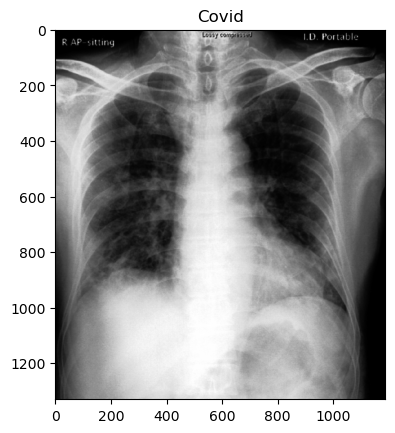

In [16]:
#visualize a covid image
covid_img = mpimg.imread("/kaggle/input/covid19-image-dataset/Covid19-dataset/train/Covid/085.jpeg")
plt.imshow(covid_img)
plt.title("Covid")
#check its shape
print(f"Image shape: {covid_img.shape}")

Image shape: (1893, 2624, 3)


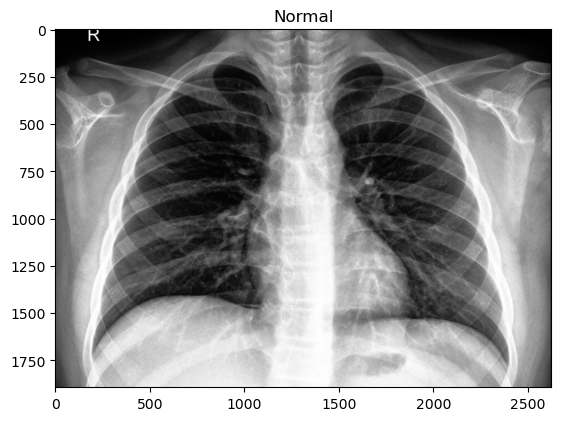

In [17]:
#visualize a Normal image
normal_img = mpimg.imread("/kaggle/input/covid19-image-dataset/Covid19-dataset/train/Normal/016.jpeg")
plt.imshow(normal_img)
plt.title("Normal")
#check its shape
print(f"Image shape: {normal_img.shape}")

Image shape: (1000, 1592, 3)


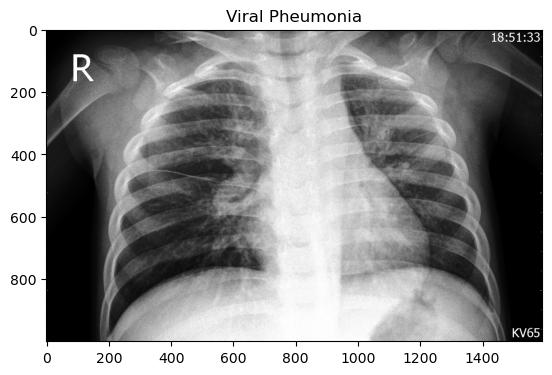

In [18]:
#visualize a Viral Pheumonia image
viral_img = mpimg.imread("/kaggle/input/covid19-image-dataset/Covid19-dataset/train/Viral Pneumonia/066.jpeg")
plt.imshow(viral_img)
plt.title("Viral Pheumonia")
#check its shape
print(f"Image shape: {viral_img.shape}")

From the visualization, I find that there are not some obvious features can be found using human eyes. Also, I find that these images are all 3-channels with viriable height and width. This gives me a basis to do image prepocessing.

In [20]:
import torchvision
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
#Data augumentation

# convert data to a normalized torch.FloatTensor
transform = torchvision.transforms.Compose([
    transforms.Resize((446,446)),
    transforms.RandomHorizontalFlip(p=0.5), # randomly flip and rotate
    transforms.ColorJitter(0.3,0.4,0.4,0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
    ])

# Augmentation on test images not needed
transform_tests = torchvision.transforms.Compose([
    transforms.Resize((446,446)),
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.255, 0.245, 0.235))
    ])

By now,I have defined the transformation for the train data and test data. Next, I need to load the data into pytorch's built in "dataloader".

In [21]:
from torch.utils.data import DataLoader
train_dir = "/kaggle/input/covid19-image-dataset/Covid19-dataset/train"
valid_dir = "/kaggle/input/covid19-image-dataset/Covid19-dataset/test"
# ImageFloder function uses for make dataset by passing dir adderess as an argument
train_data = torchvision.datasets.ImageFolder(root=train_dir,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=valid_dir,transform=transform_tests)

In [22]:
from torch.utils.data.sampler import SubsetRandomSampler
valid_size = 0.2
# Split data into train and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

#random sampling the data using SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [23]:
#load the data into Dataloader preparing for later training
train_loader = DataLoader(train_data,batch_size=8,sampler=train_sampler,num_workers=2)
valid_loader = DataLoader(train_data, batch_size =8, sampler=valid_sampler, num_workers=2)
test_loader= DataLoader(test_data,batch_size=8,shuffle=False,num_workers=2)

In [24]:
import torch
train_on_gpu = torch.cuda.is_available()

print(train_on_gpu)

device =  torch.device('cuda' if torch.cuda.is_available else 'cpu')

True


Next, I'm going to load a pretrained model to do image classification.

In [25]:
from torch import nn
import torchvision
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
#using a pretrained weight and model
model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.required_grad = False

# change the model's output to accomodate the task
ori_outputs = model.classifier[3].in_features

model.classifier[3] = nn.Linear(ori_outputs,3,True) 
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Next I need to specify the loss function and optimizer.

In [34]:
# Specify loss function and optimizer
import torch.optim as optim

#using crossEntropyLoss
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6], gamma=0.1, last_epoch=-1)

Now, I could start to train and validate my model. In most cases, this is a fixed procedure. 

PS : Some frameworks have encapsulated this procedure into easier code such as Paddlex or Keras. However,pytorch hasn't done this yet.

In [35]:
import numpy as np
# number of epochs for training
epochs = 10

# track change in validation loss
valid_loss_min = np.inf
val_loss = []
tn_loss = []
val_acc = []
tn_acc = []
for epoch in range(1,epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    train_acc = 0.0
    valid_acc = 0.0

    # Train the model
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):       
        # move tensor to gpu if cuda is available
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # clear the gradiant of all optimizer variable
        optimizer.zero_grad()
        # forward pass: compute predictions by passing inputs
        output = model(data)
        # calculate batch loss
        loss = criterion(output, target)
        # backward pass: compute gradiant of the loss with respect to the parameters
        loss.backward()
        # update parameters by optimizing single step
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        # compute train corrects
        predicted = torch.max(output.data,1)[1]
        train_correct += (predicted == target).sum()

    
    
    # validate the model

    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensor to gpu
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # forward pass: compute the validation predictions
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update the validation loss 
        valid_loss += loss.item()*data.size(0)
        
        #compute valid corrects
        predicted = torch.max(output.data,1)[1]
        valid_correct += (predicted == target).sum()
    
    # calculate average loss
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    val_loss.append(valid_loss)
    tn_loss.append(train_loss)
    
    #calculate acc
    train_acc = train_correct/len(train_loader.sampler)
    valid_acc = valid_correct/len(valid_loader.sampler)
    tn_acc.append(train_acc)
    val_acc.append(valid_acc)
    
    # update learning rate
    scheduler.step()
    # Print the train and validation loss statistic
    print('Epoch: {} \t Training Loss: {:.3f} \t Validation Loss: {:.3f} \t Training Acc:{:.3f} \t Validation Acc:{:.3f} \t'.format(epoch, train_loss, valid_loss, train_acc, valid_acc))
    
    
    # save model if validation loss decrease
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased {:.4f}--->{:.4f}  Saving model...".format(valid_loss_min, valid_loss))
        # save current model
        torch.save(model.state_dict(), 'model_state.pt')
        valid_loss_min = valid_loss
    print('Learning Rate ------------->{:.4f}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

Epoch: 1 	 Training Loss: 0.325 	 Validation Loss: 0.229 	 Training Acc:0.891 	 Validation Acc:0.980 	
Validation loss decreased inf--->0.2291  Saving model...
Learning Rate ------------->0.0100
Epoch: 2 	 Training Loss: 0.230 	 Validation Loss: 0.154 	 Training Acc:0.940 	 Validation Acc:0.960 	
Validation loss decreased 0.2291--->0.1539  Saving model...
Learning Rate ------------->0.0100
Epoch: 3 	 Training Loss: 0.232 	 Validation Loss: 0.194 	 Training Acc:0.920 	 Validation Acc:0.940 	
Learning Rate ------------->0.0100
Epoch: 4 	 Training Loss: 0.202 	 Validation Loss: 0.124 	 Training Acc:0.930 	 Validation Acc:0.960 	
Validation loss decreased 0.1539--->0.1244  Saving model...
Learning Rate ------------->0.0010
Epoch: 5 	 Training Loss: 0.138 	 Validation Loss: 0.118 	 Training Acc:0.960 	 Validation Acc:0.980 	
Validation loss decreased 0.1244--->0.1176  Saving model...
Learning Rate ------------->0.0010
Epoch: 6 	 Training Loss: 0.132 	 Validation Loss: 0.105 	 Training Acc:0

Since this dataset is too small. It's easy to obtain high accuracy on that. Now, I will plot the loss curve and the accuracy curve respectively.

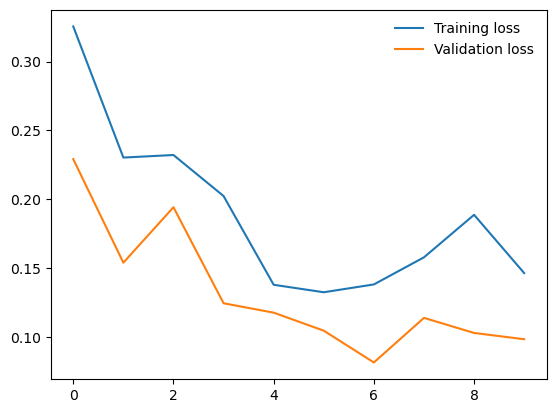

In [36]:
plt.plot(tn_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=False)


plt.show()

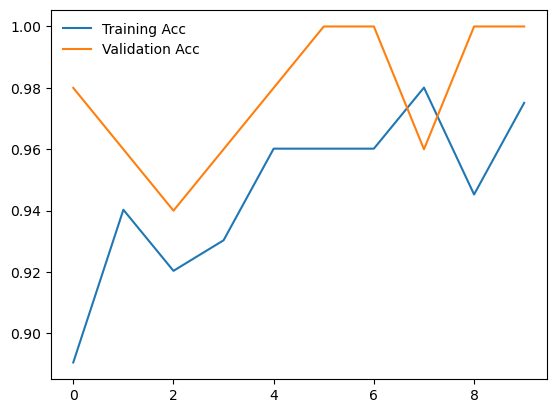

In [40]:
plt.plot(torch.tensor(tn_acc,device = 'cpu'), label='Training Acc')
plt.plot(torch.tensor(val_acc,device = 'cpu'), label='Validation Acc')
plt.legend(frameon=False)


plt.show()

Test the model on test dataset to check the actual performance.

In [46]:
correct_count, all_count = 0,0
y_test = []
y_pre = []
for images, labels in test_loader:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].view(1,3,446,446)
        with torch.no_grad():
            logps = model(img)
            
        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        y_pre.append(pred_label)
        true_label = labels.cpu()[i]
        y_test.append(true_label)
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1
        
print("Number of images Tested=", all_count)
print("\nModel Accuracy=",(correct_count/all_count)*100)

Number of images Tested= 66

Model Accuracy= 96.96969696969697


In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pre, target_names=['Covid', 'Normal', 'Viral Pheumonia']))

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      0.90      0.95        20
Viral Pheumonia       0.91      1.00      0.95        20

       accuracy                           0.97        66
      macro avg       0.97      0.97      0.97        66
   weighted avg       0.97      0.97      0.97        66



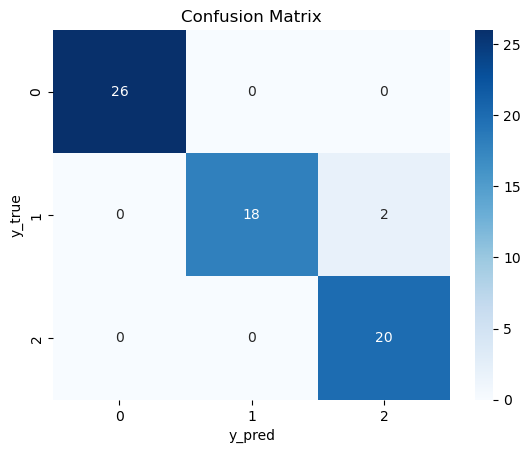

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pre)
ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()